<a href="https://colab.research.google.com/github/vladgap/Various/blob/main/2D_3D_3D%2B_function_approximation_310522.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from sklearn import preprocessing
import matplotlib.pyplot as plt
import skimage.io as sio

In [2]:
pip install MLNN

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from MLNN import*

# f(x)

In [4]:
def func(x):
    y = x**2-1
    return y

In [5]:
x=np.linspace(-1,2,11)
data1=np.array([
               x,
               func(x)
               ]).T
X1=data1[:,[0]]
T1=data1[:,[1]]

## scaling

In [6]:
scaler_X1 = preprocessing.StandardScaler().fit(X1)
scaler_T1 = preprocessing.StandardScaler().fit(T1)

# scaler_X1.mean_, scaler_X1.scale_ = 0, 1 # disable scaling
# scaler_T1.mean_, scaler_T1.scale_ = 0, 1 # disable scaling

scaler_data1 = [scaler_X1.mean_, scaler_X1.scale_, scaler_T1.mean_, scaler_T1.scale_]
print('scaler X -- mean, stdev:  ',scaler_data1[0], scaler_data1[1])
print('scaler T -- mean, stdev:  ',scaler_data1[2], scaler_data1[3])

X_sc1 = scaler_X1.transform(X1)
T_sc1 = scaler_T1.transform(T1)
X_sc1[0:3]

scaler X -- mean, stdev:   [0.5] [0.9486833]
scaler T -- mean, stdev:   [0.15] [1.23765908]


array([[-1.58113883],
       [-1.26491106],
       [-0.9486833 ]])

In [7]:
def print_scaler_data(scaler_data):
    print('scaler X -- mean, stdev:  ',scaler_data[0], scaler_data[1])
    print('scaler T -- mean, stdev:  ',scaler_data[2], scaler_data[3])

## parameter searching

In [8]:
bp_iter=VectorBackProp(layers=[1,2,1], hidden_activation = 'prelu')
learning_rate = [0.001, 0.005, 0.01]
momentum_term = [0.8, 0.9, 0.95]
learning_rate_decay = [0]
repeats = range(5)
rows=len(learning_rate) * len(momentum_term) * len(learning_rate_decay) * len(repeats)
print ('total runs:', rows)
output = np.zeros((rows,5))
i=0
weights_list = []
for lr in learning_rate:
    for mt in momentum_term:
        for lrd in learning_rate_decay:
            for rep in repeats:
                bp_iter.fit(X_sc1, T_sc1, epochs=1000, learning_rate = lr, momentum_term = mt, learning_rate_decay = lrd, repeat=False)
                relative_delta=[(a-b)/a*100 for a,b in zip(bp_iter.loss_list,[0]+bp_iter.loss_list[:-1])]
                output[i] = [lr, mt, lrd, bp_iter.loss_list[-1], relative_delta[-1]]
                weights_list.append(bp_iter.export_weights())
                print (i, end=' ')
                i+=1


total runs: 45
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 

In [9]:
output_table = pd.DataFrame(data=output, columns=['learning_rate', 'momentum_term', 'learning_rate_decay', 'final_loss', 'relative_delta'])
output_table.fillna(value = 1.1, inplace = True)
output_table.head()

learning_rate  momentum_term  learning_rate_decay  final_loss  \
0          0.001            0.8                  0.0    1.000002   
1          0.001            0.8                  0.0    0.026292   
2          0.001            0.8                  0.0    0.048308   
3          0.001            0.8                  0.0    0.048308   
4          0.001            0.8                  0.0    0.048308   

   relative_delta  
0   -1.193858e-07  
1   -1.419809e-01  
2   -4.463989e-06  
3   -4.352319e-06  
4   -5.145201e-06

In [10]:
fig = go.Figure(data=
    go.Parcoords(

        dimensions = list([
            dict(
                label = 'learning_rate', values = output_table['learning_rate']),
            dict(
                label = 'momentum_term', values = output_table['momentum_term']),
            dict(range = [0, 1],
                label = 'learning_rate_decay', values = output_table['learning_rate_decay']),
            dict(range = [0, 0.2],
                label = 'final_loss', values = output_table['final_loss']),
            dict(
                label = 'relative_delta', values = output_table['relative_delta']),
        ])
    )
)

fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white'
)

fig.show()

## running best parameters

In [11]:
bp_iter=VectorBackProp(layers=[1,2,1], hidden_activation = 'prelu')
weights_lists2=[]
loss_lists2=[]
relative_delta_lists2=[]
n = 20
for i in range(n):
    bp_iter.fit(X_sc1, T_sc1, epochs=1000, learning_rate = 0.005, momentum_term = 0.8, learning_rate_decay = 0, repeat=False)
    relative_delta=[(a-b)/a*100 for a,b in zip(bp_iter.loss_list,[0]+bp_iter.loss_list[:-1])]
    weights_lists2.append(bp_iter.export_weights())
    loss_lists2.append(bp_iter.loss_list)
    relative_delta_lists2.append(relative_delta)

In [12]:
fig2=go.Figure()
[fig2.add_trace(go.Scatter(y=loss_lists2[i][100:], name=i)) for i in range(n)]
fig2.update_layout (yaxis_range=[0,0.05], title='Loss')
fig2.show()

In [13]:
fig2=go.Figure()
[fig2.add_trace(go.Scatter(y=relative_delta_lists2[i][100:], name=i)) for i in range(n)]
fig2.update_layout (yaxis_range=[-0.5, 0.5], title='Relative delta')
fig2.show()

### Loss and relative delta

In [14]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
[fig.add_trace(go.Scatter(y=loss_lists2[i][100:], name=i),secondary_y=False) for i in range(n)]
[fig.add_trace(go.Scatter(y=relative_delta_lists2[i][100:], name=i),secondary_y=True) for i in range(n)]

fig.update_xaxes(title_text="data")
fig.update_yaxes(title_text="loss", secondary_y=False)
fig.update_yaxes(title_text="relative_delta", secondary_y=True, showgrid=False, range=[-0.01, 0.01], tick0=-0.01, dtick=.0025)
fig.update_layout(title='Loss and relative delta')
fig.show()

## best_weights_for_now

In [15]:
best_weights_for_now1=weights_lists2[9]
best_weights_for_now1

[[[-0.01848615121957436, -0.6457944755410759]],
 [[-0.08416987382155548, 1.0332500801943227]],
 [[0.08209908625856567], [-1.1869345084042748]],
 [[1.2264070862638572]]]

In [16]:
manual_best_weights_for_now1=[[[1.4679720656402142, -0.8772555603112121]],
 [[-0.2642898586862683, -0.7960946401657086]],
 [[1.4626702878650846], [1.1753619308048402]],
 [[-0.8485569587771513]]]

 # epochs=1000, learning_rate = 0.005, momentum_term = 0.8, learning_rate_decay = 0
 # loss = .0091

## fitting best parameters

In [17]:
bp1=VectorBackProp(layers=[1,2,1], hidden_activation = 'prelu')

In [18]:
bp1.import_weights(best_weights_for_now1)
# bp1.import_weights(manual_best_weights_for_now1)
bp1.fit(X_sc1, T_sc1, epochs=2000, learning_rate = 0.005, momentum_term = 0.8, learning_rate_decay = 1, repeat=True)

In [19]:
fig1=go.Figure()
fig1.add_trace(go.Scatter(y=bp1.loss_list[20:], name=''))
print('Initial loss =', bp1.loss_list[0])
print('Final loss =', bp1.loss_list[-1])
# fig1.show()

Initial loss = 0.41245593419506466
Final loss = 0.41245593419506466


## prediction

In [20]:
predics1=scaler_T1.inverse_transform(bp1.run(X_sc1))
predics1

array([[-1.35],
       [-1.05],
       [-0.75],
       [-0.45],
       [-0.15],
       [ 0.15],
       [ 0.45],
       [ 0.75],
       [ 1.05],
       [ 1.35],
       [ 1.65]])

In [21]:
errors1=(predics1-T1)/T1*100
# plt.hist(errors1[:,0]) # division by 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning:

divide by zero encountered in true_divide



In [22]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=T1[:,0], y=predics1[:,0], mode='markers', marker_size=4, name='predics', marker_color='black'),secondary_y=False)
fig.add_trace(go.Scatter(x=T1[:,0], y=T1[:,0], mode='lines', line_color='red', line_width=0.2, showlegend=False),secondary_y=False)
fig.add_trace(go.Scatter(x=T1[:,0], y=errors1[:,0], mode='markers', marker_size=4, name='errors', marker_color='orange'),secondary_y=True)

fig.update_xaxes(title_text="data")

# Set y-axes titles
fig.update_yaxes(title_text="predics", secondary_y=False)
fig.update_yaxes(title_text="% error", range=[-2, 2], secondary_y=True, showgrid=False, tick0=-5, dtick=2)

fig.show()

In [23]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=X1[:,0], y=T1[:,0], mode='markers', marker_color='blue', name='data'),secondary_y=False)
fig.add_trace(go.Scatter(x=X1[:,0], y=errors1[:,0], mode='markers', marker_size=4, marker_color='orange', name='errors'),secondary_y=True)

X_mean, X_wigth = X1[:,0].mean(), X1[:,0].max()-X1[:,0].mean()
X_extended=np.linspace(X_mean-2*X_wigth, X_mean+2*X_wigth, 51)
fig.add_trace(go.Scatter(x=X_extended, y=scaler_T1.inverse_transform(bp1.run(scaler_X1.transform(X_extended.reshape(51,1))))[:,0], mode='markers', marker_size=3, name='extenden prediction'),secondary_y=False)
fig.add_trace(go.Scatter(x=X1[:,0], y=predics1[:,0], mode='markers', marker_color='black', name='prediction'),secondary_y=False)

fig.update_xaxes(title_text="R(Sol.)")

# Set y-axes titles
fig.update_yaxes(title_text="data, predics", secondary_y=False)
fig.update_yaxes(title_text="% error", range=[-2, 2], secondary_y=True, showgrid=False, tick0=-5, dtick=2)

fig.show()

In [24]:
bp1.print_weights()

Layers (input, hidden, output):  [1, 2, 1] prelu linear
Hidden layer weights:  [[-0.01848615121957436, -0.6457944755410759]]
Hidden layer biases:  [[-0.08416987382155548, 1.0332500801943227]]
Outlet layer weights:  [[0.08209908625856567], [-1.1869345084042748]]
Outlet layer biases:  [[1.2264070862638572]]


In [25]:
print (*scaler_data1)

[0.5] [0.9486833] [0.15] [1.23765908]


In [26]:
print_scaler_data(scaler_data1)

scaler X -- mean, stdev:   [0.5] [0.9486833]
scaler T -- mean, stdev:   [0.15] [1.23765908]


# f(x1,x2)

f=x1^3-0.2*x2+5

In [27]:
data4=[
[0.32,	0.99,	0.77,	0.69,	0.04,	0.37,	0.25,	0.44,	0.42,	0.64,	0.8,],
[0.4,	0.23,	0.22,	0.57,	0.78,	0.69,	0.2,	0.45,	0.17,	0.98,	0.96,],
[4.952768,	5.924299,	5.412533,	5.214509,	4.844064,	4.912653,	4.975625,	4.995184,	5.040088,	5.066144,	5.32,],
]
data4=np.array(data4).T
X4=data4[:,[0,1]]
T4=data4[:,[2]]

In [28]:
# data4[:,0]**3-0.2*data4[:,1]+5

## scaling

In [29]:
scaler_X4 = preprocessing.StandardScaler().fit(X4)
scaler_T4 = preprocessing.StandardScaler().fit(T4)

# scaler_X4.mean_, scaler_X4.scale_ = 0, 1 # disable scaling
# scaler_T4.mean_, scaler_T4.scale_ = 0, 1 # disable scaling

scaler_data4 = [scaler_X4.mean_, scaler_X4.scale_, scaler_T4.mean_, scaler_T4.scale_]
print('scaler X -- mean, stdev:  ',scaler_data4[0], scaler_data4[1])
print('scaler T -- mean, stdev:  ',scaler_data4[2], scaler_data4[3])

X_sc4 = scaler_X4.transform(X4)
T_sc4 = scaler_T4.transform(T4)
X_sc4[0:3]

scaler X -- mean, stdev:   [0.52090909 0.51363636] [0.26752925 0.28952226]
scaler T -- mean, stdev:   [5.15071518] [0.29600926]


array([[-0.7509799 , -0.39249612],
       [ 1.75341913, -0.97967031],
       [ 0.93107915, -1.01420996]])

In [30]:
bp4=VectorBackProp(layers=[2,4,1], hidden_activation = 'prelu')

## fitting

In [31]:
bp4.fit(X_sc4, T_sc4, epochs=1000, learning_rate = 0.01, momentum_term = 0.95, learning_rate_decay = 0, init_var=.1, repeat=False)

In [32]:
fig1=go.Figure()
fig1.add_trace(go.Scatter(y=bp4.loss_list[20:], name='sigmoid'))
print('Initial loss =', bp4.loss_list[0])
print('Final loss =', bp4.loss_list[-1])

# fig1.update_yaxes(range=[0, 1])
fig1.show()

Initial loss = 1.0114265479989815
Final loss = 0.0005928531053667464


## prediction

In [33]:
predics4=scaler_T4.inverse_transform(bp4.run(X_sc4))
predics4[:,0]

array([4.96240527, 5.92429329, 5.41433599, 5.21118749, 4.83687447,
       4.92450194, 4.98077535, 4.98032549, 5.03551136, 5.06807718,
       5.31957306])

## mesh

In [34]:
x_mesh, y_mesh = np.linspace(-1, 2, 31), np.linspace(-1, 2, 31)
# x_mesh, y_mesh = np.arange(-1, 2, 0.1), np.arange(-1, 2, 0.1)
x_mesh, y_mesh = np.meshgrid(x_mesh, y_mesh)
x_mesh = x_mesh.flatten().reshape(31*31,1)
y_mesh = y_mesh.flatten().reshape(31*31,1)
mesh4=np.concatenate((x_mesh, y_mesh), axis=1)
x_mesh[:5]

array([[-1. ],
       [-0.9],
       [-0.8],
       [-0.7],
       [-0.6]])

In [35]:
mesh_predics4=scaler_T4.inverse_transform(  bp4.run( scaler_X4.transform(mesh4) )  )

## plot

In [36]:
fig_predic=go.Figure()
fig_predic.add_trace(go.Scatter3d(x=data4[:,0], y=data4[:,1], z=data4[:,2], mode='markers', name='data'))
fig_predic.add_trace(go.Scatter3d(x=data4[:,0], y=data4[:,1], z=predics4[:,0], mode='markers', name='predics'))
fig_predic.add_trace(go.Scatter3d(x=x_mesh[:,0], y=y_mesh[:,0], z=mesh_predics4[:,0], mode='markers', marker_size=2, name='mesh-predics'))
x=np.linspace(0, 1, 11)
y=np.linspace(0, 1, 11)
x, y = np.meshgrid(x,y)
z=x**3-.2*y+5
fig_predic.add_trace(go.Surface(x=x, y=y, z=z, colorbar_x=0, opacity=0.5, showlegend=True, name='data surface'))
fig_predic.update_scenes(camera_projection_type="orthographic")

fig_predic.show()

In [37]:
# bp4.JWh_history[-1]

# f(x1,x2) - density (R(K),R(SO4))

In [38]:
data2=[
[62.8,	49.9,	44.3,	39.4,	66.2, 59.2, 51.4, 94.5,	90.9, 94.3, 90.9, 45.1, 37.4, 33.6, 28.9, 35.2, 100, 82.1,	90.6,	84.6,	88.9,	92.9],
[28.1,	26.9,	26.6,	24.6,	24.3, 29.5, 27.6, 24.1,	31.6, 27.3, 30.9, 19.0, 21.4, 23.3, 24.5, 25.5, 0, 11.7,	6.1,	25.3,	18.1,	11.6],
[1127,	867,	850,	783,	1196,	1067,	962,	1543,	1430,	1544,	1440,	931,	770,	734,	655,	757,	2033,	1586,	1767,	1393,	1594,	1745],
[1.313,	1.373,	1.389,	1.408,	1.293,	1.326,	1.355, 1.237,	1.25,	1.263,	1.253, 1.364, 1.406, 1.440, 1.460, 1.427, 1.207, 1.239,	1.22,	1.246,	1.25,	1.222],
]
data2=np.array(data2).T

In [39]:
X2=data2[:,[0,1]]
T2=data2[:,[3]]

## scaling

In [40]:
scaler_X2 = preprocessing.StandardScaler().fit(X2)
scaler_T2 = preprocessing.StandardScaler().fit(T2)

# scaler_X2.mean_, scaler_X2.scale_ = 0, 1 # disable scaling
# scaler_T2.mean_, scaler_T2.scale_ = 0, 1 # disable scaling

scaler_data2 = [scaler_X2.mean_, scaler_X2.scale_, scaler_T2.mean_, scaler_T2.scale_]
print('scaler X -- mean, stdev:  ',scaler_data2[0], scaler_data2[1])
print('scaler T -- mean, stdev:  ',scaler_data2[2], scaler_data2[3])

X_sc2 = scaler_X2.transform(X2)
T_sc2 = scaler_T2.transform(T2)
X_sc2[0:3]

scaler X -- mean, stdev:   [66.50454545 22.18181818] [24.11980471  7.95410908]
scaler T -- mean, stdev:   [1.3155] [0.07992198]


array([[-0.15358936,  0.74404082],
       [-0.68841956,  0.5931754 ],
       [-0.92059392,  0.55545904]])

## parameter searching

In [41]:
bp_iter=VectorBackProp(layers=[2,2,1], hidden_activation = 'sigmoid')
learning_rate = [0.001, 0.005, 0.01]
momentum_term = [0.8, 0.9, 0.95]
learning_rate_decay = [0]
repeats = range(5)
rows=len(learning_rate) * len(momentum_term) * len(learning_rate_decay) * len(repeats)
print ('total runs:', rows)
output = np.zeros((rows,5))
i=0
weights_list = []
for lr in learning_rate:
    for mt in momentum_term:
        for lrd in learning_rate_decay:
            for rep in repeats:
                bp_iter.fit(X_sc2, T_sc2, epochs=2000, learning_rate = lr, momentum_term = mt, learning_rate_decay = lrd, repeat=False)
                relative_delta=[(a-b)/a*100 for a,b in zip(bp_iter.loss_list,[0]+bp_iter.loss_list[:-1])]
                output[i] = [lr, mt, lrd, bp_iter.loss_list[-1], relative_delta[-1]]
                weights_list.append(bp_iter.export_weights())
                print (i, end=' ')
                i+=1


total runs: 45
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 

In [42]:
output_table = pd.DataFrame(data=output, columns=['learning_rate', 'momentum_term', 'learning_rate_decay', 'final_loss', 'relative_delta'])
output_table.fillna(value = 1.1, inplace = True)
output_table.head()

learning_rate  momentum_term  learning_rate_decay  final_loss  \
0          0.001            0.8                  0.0    0.007761   
1          0.001            0.8                  0.0    0.008777   
2          0.001            0.8                  0.0    0.010590   
3          0.001            0.8                  0.0    0.009700   
4          0.001            0.8                  0.0    0.009309   

   relative_delta  
0       -0.027237  
1       -0.039846  
2       -0.034016  
3       -0.040261  
4       -0.035599

In [43]:
fig = go.Figure(data=
    go.Parcoords(

        dimensions = list([
            dict(
                label = 'learning_rate', values = output_table['learning_rate']),
            dict(
                label = 'momentum_term', values = output_table['momentum_term']),
            dict(range = [0, 1],
                label = 'learning_rate_decay', values = output_table['learning_rate_decay']),
            dict(range = [0, 0.2],
                label = 'final_loss', values = output_table['final_loss']),
            dict(
                label = 'relative_delta', values = output_table['relative_delta']),
        ])
    )
)

fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white'
)

fig.show()

## running best parameters

In [44]:
bp_iter=VectorBackProp(layers=[2,2,1], hidden_activation = 'sigmoid')
weights_lists2=[]
loss_lists2=[]
relative_delta_lists2=[]
n = 20
for i in range(n):
    bp_iter.fit(X_sc2, T_sc2, epochs=1000, learning_rate = 0.01, momentum_term = 0.9, learning_rate_decay = 0., repeat=False)
    relative_delta=[(a-b)/a*100 for a,b in zip(bp_iter.loss_list,[0]+bp_iter.loss_list[:-1])]
    weights_lists2.append(bp_iter.export_weights())
    loss_lists2.append(bp_iter.loss_list)
    relative_delta_lists2.append(relative_delta)

In [45]:
fig2=go.Figure()
[fig2.add_trace(go.Scatter(y=loss_lists2[i][100:], name=i)) for i in range(n)]
fig2.update_layout (yaxis_range=[0,0.02])
fig2.show()

In [46]:
fig2=go.Figure()
[fig2.add_trace(go.Scatter(y=relative_delta_lists2[i][100:], name=i)) for i in range(n)]
fig2.update_layout (yaxis_range=[-0.5, 0.5], title='Relative delta')
fig2.show()

## best_weights_for_now

In [47]:
best_weights_for_now2=weights_lists2[0]
best_weights_for_now2

[[[-1.6154228886584054, -0.3317802254384632],
  [0.202306354530298, 0.4107336929625988]],
 [[-1.6547324889406119, 0.5183992560248881]],
 [[3.5794843965303977], [1.1749303783722151]],
 [[-1.675274872836622]]]

In [48]:
manual_best_weights_for_now2=[[[1.5034804871808578, 0.03551232897431893],
  [-0.15121908487533917, 0.5606629421212576]],
 [[1.510200700696482, 0.41341888240448166]],
 [[-4.030693671600399], [0.8879135898852777]],
 [[2.402298178126899]]]

 # epochs=1000, learning_rate = 0.01, momentum_term = 0.9, learning_rate_decay = 0.
 # loss = .00535

## fitting best parameters

In [49]:
bp2=VectorBackProp(layers=[2,2,1], hidden_activation = 'sigmoid')

In [50]:
# bp2.import_weights(best_weights_for_now2)
bp2.import_weights(manual_best_weights_for_now2)
bp2.fit(X_sc2, T_sc2, epochs=1, learning_rate = 0., momentum_term = 0., learning_rate_decay = 0., repeat=True)

In [51]:
fig1=go.Figure()
fig1.add_trace(go.Scatter(y=bp2.loss_list[20:], name=''))
print('Initial loss =', bp2.loss_list[0])
print('Final loss =', bp2.loss_list[-1])
# fig1.show()

Initial loss = 0.00535568063098292
Final loss = 0.00535568063098292


## prediction

In [52]:
predics2=scaler_T2.inverse_transform(bp2.run(X_sc2))
predics2

array([[1.31118713],
       [1.36351517],
       [1.39032861],
       [1.40939561],
       [1.29171819],
       [1.32815164],
       [1.35813918],
       [1.24339949],
       [1.25635661],
       [1.24784182],
       [1.25547686],
       [1.36574307],
       [1.41058305],
       [1.43376965],
       [1.45744103],
       [1.43203208],
       [1.20874973],
       [1.23615092],
       [1.22040667],
       [1.25485092],
       [1.23916186],
       [1.22651414]])

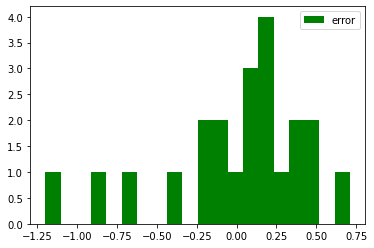

In [53]:
errors2=(predics2-T2)/T2*100
plt.hist(errors2[:,0], 20, color='green')
plt.legend(['error'])
plt.show()

In [54]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=T2[:,0], y=predics2[:,0], mode='markers', marker_size=4, name='predics', marker_color='black'),secondary_y=False)
fig.add_trace(go.Scatter(x=T2[:,0], y=T2[:,0], mode='lines', line_color='red', line_width=0.2, showlegend=False),secondary_y=False)
fig.add_trace(go.Scatter(x=T2[:,0], y=errors2[:,0], mode='markers', marker_size=4, name='errors', marker_color='orange'),secondary_y=True)

fig.update_xaxes(title_text="data")

fig.update_yaxes(title_text="predics", secondary_y=False)
fig.update_yaxes(title_text="% error", range=[-2, 2], secondary_y=True, showgrid=False, tick0=-5, dtick=2)

fig.show()

## mesh

In [55]:
x_mesh, y_mesh = np.linspace(10, 120, 31), np.linspace(-20, 50, 31)
# x_mesh, y_mesh = np.arange(-1, 2, 0.1), np.arange(-1, 2, 0.1)
x_mesh, y_mesh = np.meshgrid(x_mesh, y_mesh)
x_mesh = x_mesh.flatten().reshape(31*31,1)
y_mesh = y_mesh.flatten().reshape(31*31,1)
mesh2=np.concatenate((x_mesh, y_mesh), axis=1)
x_mesh[:5]

array([[10.        ],
       [13.66666667],
       [17.33333333],
       [21.        ],
       [24.66666667]])

In [56]:
mesh_predics2=scaler_T2.inverse_transform(  bp2.run( scaler_X2.transform(mesh2) )  )

## surface exponent excel

In [57]:
def make_xy_grid(A, B, C, D, n=2, m=2):
  n=n # horizontal dots number. min -- 2
  m=m # vertical dots number. min --2
  x=np.linspace(0,1,n)
  y=np.linspace(0,1,m)
  x,y = np.meshgrid(x,y)

  x[0][0], y[0][0]=A[0], A[1]
  x[0][n-1], y[0][n-1]=B[0], B[1]
  x[m-1][0], y[m-1][0]=C[0], C[1]
  x[m-1][n-1], y[m-1][n-1]=D[0], D[1]
  # print (x)
  # print (y)
  # vertical boundary interpol.
  for i in range(1, m-1):
    x[i][0]=x[0][0]+(x[m-1][0]-x[0][0])/m*i
    x[i][n-1]=x[0][n-1]+(x[m-1][n-1]-x[0][n-1])/m*i
    y[i][0]=y[0][0]+(y[m-1][0]-y[0][0])/m*i
    y[i][n-1]=y[0][n-1]+(y[m-1][n-1]-y[0][n-1])/m*i
  # print (x)
  # print (y)
  # horizontal inner interpol.
  for i in range(m):
    for j in range(1, n-1):
      x[i][j]=x[i][0]+(x[i][n-1]-x[i][0])/n*j
      y[i][j]=y[i][0]+(y[i][n-1]-y[i][0])/n*j
  # print (x)
  # print (y)
  return x,y

In [58]:
A=[100,0]
B=[94,32]
C=[28.9,24.5]
D=[59.2,29.5]
x45,y45=make_xy_grid(A,B,C,D,8,8)
z45=x45*14.18+y45*(-13.84)+581.1

In [59]:
x45

array([[100.       ,  99.25     ,  98.5      ,  97.75     ,  97.       ,
         96.25     ,  95.5      ,  94.       ],
       [ 91.1125   ,  90.9296875,  90.746875 ,  90.5640625,  90.38125  ,
         90.1984375,  90.015625 ,  89.65     ],
       [ 82.225    ,  82.609375 ,  82.99375  ,  83.378125 ,  83.7625   ,
         84.146875 ,  84.53125  ,  85.3      ],
       [ 73.3375   ,  74.2890625,  75.240625 ,  76.1921875,  77.14375  ,
         78.0953125,  79.046875 ,  80.95     ],
       [ 64.45     ,  65.96875  ,  67.4875   ,  69.00625  ,  70.525    ,
         72.04375  ,  73.5625   ,  76.6      ],
       [ 55.5625   ,  57.6484375,  59.734375 ,  61.8203125,  63.90625  ,
         65.9921875,  68.078125 ,  72.25     ],
       [ 46.675    ,  49.328125 ,  51.98125  ,  54.634375 ,  57.2875   ,
         59.940625 ,  62.59375  ,  67.9      ],
       [ 28.9      ,  32.6875   ,  36.475    ,  40.2625   ,  44.05     ,
         47.8375   ,  51.625    ,  59.2      ]])

In [60]:
den45=60.7073*z45**(-0.7507)+1
MKP_45C_density_exponent=go.Surface(
    contours = {
        "z": {"show": True, "start": 1.1, "end": 1.5, "size": .025, 'color':'grey'}
    },
    x = x45, y = y45, z = den45, 
    connectgaps=False,
    opacity=0.3,
    name='45C density surface',
    showlegend=True,
    # showscale=False,
    colorbar=dict(
            title='צפיפות', # title here
            titleside='right',
            len=0.5),
    colorscale='Rainbow',
    cmin=1.1, cmax=1.5,
)

## surface sigmoids

In [61]:
x45.shape

(8, 8)

In [62]:
x_mesh_sigm = x45.flatten().reshape(8*8,1)
y_mesh_sigm = y45.flatten().reshape(8*8,1)
mesh_sigm=np.concatenate((x_mesh_sigm, y_mesh_sigm), axis=1)
x_mesh_sigm[:5]

array([[100.  ],
       [ 99.25],
       [ 98.5 ],
       [ 97.75],
       [ 97.  ]])

In [63]:
MKP_45C_density_sigmoid=scaler_T2.inverse_transform(  bp2.run( scaler_X2.transform(mesh_sigm) )  )
MKP_45C_density_sigmoid.reshape(8,8)

array([[1.20874973, 1.21346436, 1.21872692, 1.22443014, 1.23042168,
        1.23652459, 1.24256558, 1.25394282],
       [1.21622396, 1.22090968, 1.22597313, 1.23131294, 1.23680378,
        1.24231096, 1.24770749, 1.25778461],
       [1.22752414, 1.23179962, 1.23628789, 1.24090421, 1.24555374,
        1.25014056, 1.25457686, 1.26273032],
       [1.24489709, 1.24799354, 1.25118749, 1.25441716, 1.25761827,
        1.2607287 , 1.26369295, 1.26901292],
       [1.27116819, 1.27177828, 1.27249465, 1.27327657, 1.2740837 ,
        1.27487821, 1.27562653, 1.27687926],
       [1.30857211, 1.30504722, 1.30177785, 1.29874821, 1.29594075,
        1.29333709, 1.2909189 , 1.28656955],
       [1.35633027, 1.34761955, 1.33922626, 1.33121585, 1.32364107,
        1.31654115, 1.30994186, 1.2982857 ],
       [1.45744103, 1.44262074, 1.42664672, 1.40984914, 1.39263252,
        1.3754406 , 1.35871345, 1.32815164]])

In [64]:
MKP_45C_density_sigmoids=go.Surface(
    contours = {
        "z": {"show": True, "start": 1.1, "end": 1.5, "size": .025, 'color':'grey'}
    },
    x = x45, y = y45, z = MKP_45C_density_sigmoid.reshape(8,8), 
    connectgaps=False,
    opacity=0.3,
    name='45C density surface sigmoids',
    showlegend=True,
    # showscale=False,
    colorbar=dict(
            title='צפיפות', # title here
            titleside='right',
            len=0.5),
    colorscale='Rainbow',
    cmin=1.1, cmax=1.5,
)

## plot

In [65]:
fig_predic=go.Figure()
fig_predic.add_trace(go.Scatter3d(x=data2[:,0], y=data2[:,1], z=data2[:,3], mode='markers', marker_size=6, name='data'))
fig_predic.add_trace(go.Scatter3d(x=data2[:,0], y=data2[:,1], z=predics2[:,0], mode='markers', marker_size=6, name='predics'))
fig_predic.add_trace(go.Scatter3d(x=x_mesh[:,0], y=y_mesh[:,0], z=mesh_predics2[:,0], mode='markers', marker_size=2, name='mesh-predics', visible='legendonly'))
# fig_predic.add_trace(MKP_45C_density_exponent)
fig_predic.add_trace(MKP_45C_density_sigmoids)

x = np.linspace(-14,120, 456)
y = np.linspace(-20,107, 484)
x, y = np.meshgrid(x,y)
image = sio.imread ("https://vladgap.github.io/MKP-web/MKP%20diag%20pic_red.jpg") 
# print(image.shape)
img = image[:,:, 1] 
Z = 0 * np.ones(x.shape)+1.101
# fig_predic.add_surface(x=x, y=y, z=Z, 
#                 surfacecolor=np.flipud(img), 
#                 colorscale='gray', 
#                 showscale=False,
#                 hoverinfo='none',
#                )

fig_predic.update_layout(
    scene = {
        "xaxis": {"range":[0,100], "nticks": 20},
        "yaxis": {"range":[0,100], "nticks": 20},
        "zaxis": {"range":[1.1,1.5], "nticks": 6},
        'xaxis_title': 'R(K)',
        'yaxis_title': 'R(SO4)',
        'zaxis_title': 'צפיפות',
        'camera_eye': {"x": 1.5, "y": -1.5, "z": .7},
        "aspectratio": {"x": 1, "y": 1, "z": 0.6},
        'camera_center': {"x": 0, "y": 0, "z": -0.01}
    },
    width=1000, height=1000,
    margin=dict(l=30, r=30, b=30, t=30),
    title_text='צפיפות תמיסת אם ב-45 מעלות',
    title_x=0.5,
)
fig_predic.update_scenes(camera_projection_type="orthographic")
# fig_predic.write_html("Na,K..H2PO4,SO4 density ortho 170522.html")

fig_predic.show()

In [66]:
bp2.print_weights()

Layers (input, hidden, output):  [2, 2, 1] sigmoid linear
Hidden layer weights:  [[1.5034804871808578, 0.03551232897431893], [-0.15121908487533917, 0.5606629421212576]]
Hidden layer biases:  [[1.510200700696482, 0.41341888240448166]]
Outlet layer weights:  [[-4.030693671600399], [0.8879135898852777]]
Outlet layer biases:  [[2.402298178126899]]


In [67]:
print_scaler_data(scaler_data2)

scaler X -- mean, stdev:   [66.50454545 22.18181818] [24.11980471  7.95410908]
scaler T -- mean, stdev:   [1.3155] [0.07992198]


# f(x1,x2) - Partial pressure(C,T)

In [68]:
data3=[
[0,	5,	10,	15,	20,	25,	30,	35,	40,	45,	50,	55,	60,	65,	70,	75,	80,	85,	90,	95,	100,	0,	5,	10,	15,	20,	25,	30,	35,	40,	45,	50,	55,	60,	65,	70,	75,	80,	85,	90,	95,	100,	0,	5,	10,	15,	20,	25,	30,	35,	40,	45,	50,	55,	60,	65,	70,	75,	80,	85,	90,	95,	100,0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 65, 70, 75, 80, 85, 90, 95, 100, 75, 80, 85, 90, 95, 100, 80, 85, 90, 95, 100, ],
[20,	20,	20,	20,	20,	20,	20,	20,	20,	20,	20,	20,	20,	20,	20,	20,	20,	20,	20,	20,	20,	30,	30,	30,	30,	30,	30,	30,	30,	30,	30,	30,	30,	30,	30,	30,	30,	30,	30,	30,	30,	30,	40,	40,	40,	40,	40,	40,	40,	40,	40,	40,	40,	40,	40,	40,	40,	40,	40,	40,	40,	40,	40,50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 130, 130, 130, 130, 130, 130, 130, 130, 140, 140, 140, 140, 140, 140, 150, 150, 150, 150, 150, ],
[23.158,	23.026,	22.763,	22.632,	22.368,	22.105,	21.447,	20.658,	19.474,	18.289,	17.105,	15.526,	13.684,	11.842,	9.737,	7.434,	5.066,	2.842,	1.184,	0.338,	0.038,	41.842,	41.447,	40.789,	39.737,	39.474,	39.211,	38.026,	36.711,	34.474,	32.632,	30.395,	27.5,	24.211,	20.921,	17.237,	13.158,	9.079,	5.197,	2.25,	0.683,	0.078,	72.763,	71.711,	71.316,	70.921,	69.737,	68.421,	66.447,	64.079,	60.658,	56.974,	53.026,	47.368,	42.237,	35.526,	29.605,	23.026,	15.921,	9.145,	4.211,	1.342,	0.158,121.842, 118.421, 115.789, 114.474, 113.158, 110.526, 107.895, 103.947, 98.684, 92.5, 86.579, 77.237, 68.421, 57.895, 48.026, 37.895, 26.184, 15.395, 7.368, 2.447, 0.301, 197.368, 193.421, 192.105, 188.158, 185.526, 184.211, 178.947, 171.053, 161.842, 152.632, 142.105, 126.316, 110.921, 93.421, 78.026, 61.842, 42.895, 25.921, 12.763, 4.382, 0.566, 307.895, 302.632, 300, 296.053, 289.474, 286.842, 277.632, 268.421, 253.947, 239.474, 223.684, 197.368, 175, 146.053, 121.053, 97.368, 68.421, 41.711, 21.316, 7.566, 1.02, 467.105, 463.158, 460.526, 453.947, 448.684, 444.737, 430.263, 409.211, 385.526, 361.842, 338.158, 298.684, 263.158, 221.053, 184.211, 146.053, 102.632, 64.211, 34.211, 12.671, 1.75, 692.105, 686.842, 682.895, 673.684, 665.789, 660.526, 638.158, 615.789, 589.474, 553.947, 517.105, 473.684, 415.789, 348.684, 293.421, 219.737, 157.895, 99.342, 53.947, 20.658, 3, 1000, 993.421, 990.789, 977.632, 967.105, 959.211, 927.632, 901.316, 863.158, 810.526, 756.579, 686.842, 605.263, 510.526, 423.684, 315.789, 227.632, 146.053, 81.579, 32.763, 4.803, 1414.474, 1405.263, 1402.632, 1384.211, 1368.421, 1356.579, 1310.526, 1276.316, 1221.053, 1147.368, 1071.053, 961.842, 817.105, 689.474, 572.368, 447.368, 322.368, 210.526, 122.368, 50.658, 7.632, 1325, 1118.421, 953.947, 797.368, 631.579, 453.947, 300, 178.947, 76.842, 11.842, 1315.789, 1098.684, 868.421, 631.579, 423.684, 259.211, 114.079, 17.237, 1177.632, 861.842, 585.526, 364.474, 165.789, 26.711, 1157.895, 789.474, 503.947, 243.421, 38.816, ]
]
#[C]
#[T]
#[P]
data3=np.array(data3).T

In [69]:
X3=data3[:,[0,1]]
T3=data3[:,[2]]

## scaling

In [70]:
scaler_X3 = preprocessing.StandardScaler().fit(X3)
scaler_T3 = preprocessing.StandardScaler().fit(T3)

# scaler_X3.mean_, scaler_X3.scale_ = 0, 1 # disable scaling
# scaler_T3.mean_, scaler_T3.scale_ = 0, 1 # disable scaling

scaler_data3 = [scaler_X3.mean_, scaler_X3.scale_, scaler_T3.mean_, scaler_T3.scale_]
print('scaler X -- mean, stdev:  ',scaler_data3[0], scaler_data3[1])
print('scaler T -- mean, stdev:  ',scaler_data3[2], scaler_data3[3])

X_sc3 = scaler_X3.transform(X3)
T_sc3 = scaler_T3.transform(T3)
X_sc3[0:3]

scaler X -- mean, stdev:   [54.0167364  73.13807531] [30.67537774 34.91450667]
scaler T -- mean, stdev:   [305.48522594] [375.99549062]


array([[-1.76091512, -1.52194834],
       [-1.59791794, -1.52194834],
       [-1.43492076, -1.52194834]])

## parameter searching

In [71]:
bp_iter=VectorBackProp(layers=[2,4,1], hidden_activation = 'sigmoid')
learning_rate = [0.001, 0.005, 0.01, 0.05]
momentum_term = [0.7, 0.8, 0.9]
learning_rate_decay = [0, 1]
repeats = range(10)
rows=len(learning_rate) * len(momentum_term) * len(learning_rate_decay) * len(repeats)
print ('total runs:', rows)
output = np.zeros((rows,5))
i=0
weights_list = []
for lr in learning_rate:
    for mt in momentum_term:
        for lrd in learning_rate_decay:
            for rep in repeats:
                bp_iter.fit(X_sc3, T_sc3, epochs=1000, learning_rate = lr, momentum_term = mt, learning_rate_decay = lrd, repeat=False)
                relative_delta=[(a-b)/a*100 for a,b in zip(bp_iter.loss_list,[0]+bp_iter.loss_list[:-1])]
                output[i] = [lr, mt, lrd, bp_iter.loss_list[-1], relative_delta[-1]]
                weights_list.append(bp_iter.export_weights())
                print (i, end=' ')
                if i%25==0 and i>0:
                    print ('\n')
                i+=1


total runs: 240
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 

26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 

51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 

76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 

126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 

151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 

176 177 178 179 180 

/usr/local/lib/python3.7/dist-packages/MLNN/MLNN.py:362: RuntimeWarning:

overflow encountered in exp

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:48: RuntimeWarning:

overflow encountered in reduce

/usr/local/lib/python3.7/dist-packages/MLNN/MLNN.py:418: RuntimeWarning:

overflow encountered in square

/usr/local/lib/python3.7/dist-packages/MLNN/MLNN.py:445: RuntimeWarning:

overflow encountered in matmul

/usr/local/lib/python3.7/dist-packages/MLNN/MLNN.py:445: RuntimeWarning:

invalid value encountered in multiply

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning:

invalid value encountered in double_scalars



181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 

201 202 203 204 

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning:

overflow encountered in reduce



205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 

226 227 228 229 230 231 232 233 234 235 236 237 238 239 

In [72]:
output_table = pd.DataFrame(data=output, columns=['learning_rate', 'momentum_term', 'learning_rate_decay', 'final_loss', 'relative_delta'])
output_table.fillna(value = 1.1, inplace = True)
output_table.head()

learning_rate  momentum_term  learning_rate_decay  final_loss  \
0          0.001            0.7                  0.0    0.041860   
1          0.001            0.7                  0.0    0.181520   
2          0.001            0.7                  0.0    0.181448   
3          0.001            0.7                  0.0    0.181523   
4          0.001            0.7                  0.0    0.181520   

   relative_delta  
0       -0.061634  
1       -0.000031  
2       -0.000097  
3       -0.000067  
4       -0.000055

In [73]:
output_table.sort_values('final_loss').head()

learning_rate  momentum_term  learning_rate_decay  final_loss  \
108          0.005            0.9                  0.0    0.006924   
88           0.005            0.8                  0.0    0.009359   
106          0.005            0.9                  0.0    0.012203   
65           0.005            0.7                  0.0    0.012839   
69           0.005            0.7                  0.0    0.013880   

     relative_delta  
108       -0.014630  
88        -0.162942  
106      -24.663970  
65        -0.204062  
69        -0.284949

In [74]:
weights_list[101]

[[[-1.089441348055994,
   -4.321162798676458,
   1.8308512820914642,
   1.1081362287205336],
  [1.6161502864186301,
   2.3343845585238965,
   2.3123253959161314,
   -2.3151273646736237]],
 [[-9.533634313009445,
   -6.847022919041667,
   -6.378955912783363,
   2.6390345208201134]],
 [[2.6573958718277035],
  [-1.685591599863618],
  [-4.416519571982605],
  [-5.842530829492149]],
 [[5.1596352524885125]]]

In [75]:
fig = go.Figure(data=
    go.Parcoords(

        dimensions = list([
            dict(
                label = 'learning_rate', values = output_table['learning_rate']),
            dict(
                label = 'momentum_term', values = output_table['momentum_term']),
            dict(range = [0, 1],
                label = 'learning_rate_decay', values = output_table['learning_rate_decay']),
            dict(range = [0, 0.2],
                label = 'final_loss', values = output_table['final_loss']),
            dict(
                label = 'relative_delta', values = output_table['relative_delta']),
        ])
    )
)

fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white'
)

fig.show()

## running best parameters

In [76]:
bp_iter2=VectorBackProp(layers=[2,4,1], hidden_activation = 'sigmoid')
weights_lists2=[]
loss_lists2=[]
relative_delta_lists2=[]
n = 20
for i in range(n):
    bp_iter2.fit(X_sc3, T_sc3, epochs=3000, learning_rate = 0.005, momentum_term = 0.9, learning_rate_decay = 0, repeat=False)
    relative_delta=[(a-b)/a*100 for a,b in zip(bp_iter2.loss_list,[0]+bp_iter.loss_list[:-1])]
    weights_lists2.append(bp_iter2.export_weights())
    loss_lists2.append(bp_iter2.loss_list)
    relative_delta_lists2.append(relative_delta)

In [77]:
fig2=go.Figure()
[fig2.add_trace(go.Scatter(y=loss_lists2[i][100:], name=i)) for i in range(n)]
fig2.update_layout (yaxis_range=[0,0.02])
fig2.show()

In [78]:
fig2=go.Figure()
[fig2.add_trace(go.Scatter(y=relative_delta_lists2[i][100:], name=i)) for i in range(n)]
fig2.update_layout (yaxis_range=[-0.5, 0.5], title='Relative delta')
fig2.show()

## best_weights_for_now

In [79]:
best_weights_for_now3=weights_lists2[19]
best_weights_for_now3

[[[-4.068949459389271,
   -3.1849160454877707,
   1.7871502239818355,
   -2.082967766655441],
  [0.4486274556165772,
   1.0817039637018955,
   -0.025830926540322558,
   2.82823109363936]],
 [[2.861340504094501,
   -0.7732436103873137,
   0.6339370289121777,
   -4.7009034004747825]],
 [[1.6536498627476561],
  [3.66858761502041],
  [5.861376780080323],
  [4.1566177045794195]],
 [[-6.568417781999778]]]

In [80]:
manual_best_weights_for_now3=[[[0.823346203392654,
   -2.585372703897094,
   1.7081601794777435,
   2.6181769832418573],
  [-2.23955096147628,
   -0.36366754869557927,
   2.2442674271536402,
   -0.8426118192031995]],
 [[3.3467976041271066,
   -1.8467725891491473,
   -6.490382333576185,
   0.3961700785714912]],
 [[-6.0731476856592055],
  [-1.6844139337137223],
  [-4.715033206714522],
  [-1.7169339753371398]],
 [[7.0017467515267215]]]
 # epochs=3000, learning_rate = 0.005, momentum_term = 0.9, learning_rate_decay = 0
 # loss = 0.00759

## fitting best parameters

In [81]:
bp3=VectorBackProp(layers=[2,4,1], hidden_activation = 'sigmoid')

In [82]:
# bp3.import_weights(best_weights_for_now3)
bp3.import_weights(manual_best_weights_for_now3)
bp3.fit(X_sc3, T_sc3, epochs=10000, learning_rate = 0.03, momentum_term = 0.95, learning_rate_decay = 1, repeat=True)

In [83]:
fig1=go.Figure()
fig1.add_trace(go.Scatter(y=bp3.loss_list[20:], name=''))
print('Initial loss =', bp3.loss_list[0])
print('Final loss =', bp3.loss_list[-1])
fig1.show()

Initial loss = 0.007594885219419072
Final loss = 0.007359246639785838


## prediction

In [84]:
predics3=scaler_T3.inverse_transform(bp3.run(X_sc3))
# predics3

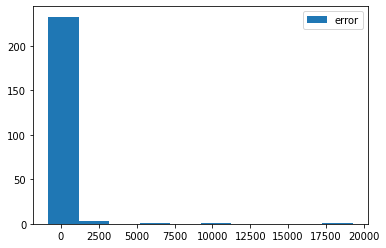

In [85]:
errors3=(predics3-T3)/T3*100
plt.hist(errors3[:,0])
plt.legend(['error'])
plt.show()

In [86]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=T3[:,0], y=predics3[:,0], mode='markers', marker_size=4, name='predics', marker_color='black'),secondary_y=False)
fig.add_trace(go.Scatter(x=T3[:,0], y=T3[:,0], mode='lines', line_color='red', line_width=0.2, showlegend=False),secondary_y=False)
fig.add_trace(go.Scatter(x=T3[:,0], y=errors3[:,0], mode='markers', marker_size=4, name='errors', marker_color='orange'),secondary_y=True)

fig.update_xaxes(title_text="data")

fig.update_yaxes(title_text="predics", secondary_y=False)
fig.update_yaxes(title_text="% error", range=[-10, 10], secondary_y=True, showgrid=False, tick0=-5, dtick=2)

fig.show()

## mesh

In [87]:
x_mesh, y_mesh = np.linspace(0, 100, 31), np.linspace(20, 150, 31)
# x_mesh, y_mesh = np.arange(-1, 2, 0.1), np.arange(-1, 2, 0.1)
x_mesh, y_mesh = np.meshgrid(x_mesh, y_mesh)
x_mesh = x_mesh.flatten().reshape(31*31,1)
y_mesh = y_mesh.flatten().reshape(31*31,1)
mesh3=np.concatenate((x_mesh, y_mesh), axis=1)
x_mesh[:5]

array([[ 0.        ],
       [ 3.33333333],
       [ 6.66666667],
       [10.        ],
       [13.33333333]])

In [88]:
mesh_predics3=scaler_T3.inverse_transform(  bp3.run( scaler_X3.transform(mesh3) )  )

## plot

In [89]:
fig_predic=go.Figure()
fig_predic.add_trace(go.Scatter3d(x=data3[:,0], y=data3[:,1], z=data3[:,2], mode='markers', marker_size=6, name='data'))
fig_predic.add_trace(go.Scatter3d(x=data3[:,0], y=data3[:,1], z=predics3[:,0], mode='markers', marker_size=6, name='predics'))
fig_predic.add_trace(go.Scatter3d(x=x_mesh[:,0], y=y_mesh[:,0], z=mesh_predics3[:,0], mode='markers', marker_size=2, name='mesh-predics', visible='legendonly'))

fig_predic.update_layout(
    scene = {
        "xaxis": {"range":[0,100], "nticks": 20},
        "yaxis": {"range":[20,150], "nticks": 20},
        # "zaxis": {"range":[1.1,1.5], "nticks": 6},
        'xaxis_title': '%H3PO4',
        'yaxis_title': 'Temperature, C',
        'zaxis_title': 'Pressure, mbar',
        'camera_eye': {"x": 1.5, "y": -1.5, "z": .7},
        "aspectratio": {"x": 1, "y": 1, "z": 0.6},
        'camera_center': {"x": 0, "y": 0, "z": -0.01}
    },
    width=1000, height=1000,
    margin=dict(l=30, r=30, b=30, t=30),
    title_text=' ',
    title_x=0.5,
)
fig_predic.update_scenes(camera_projection_type="orthographic")
# fig_predic.write_html("Na,K..H2PO4,SO4 density ortho 170522.html")

fig_predic.show()

In [90]:
bp3.print_weights()

Layers (input, hidden, output):  [2, 4, 1] sigmoid linear
Hidden layer weights:  [[0.8072846282920318, -2.5294820162557032, 1.6353084608789474, 2.548967112384343], [-2.227832973304566, -0.2852300972735733, 2.218128334876839, -0.8321259264011608]]
Hidden layer biases:  [[3.357216785926393, -1.817122738265093, -6.368237983036173, 0.46260097605455747]]
Outlet layer weights:  [[-6.206773164108749], [-1.795114906436459], [-4.874143431009051], [-1.8255413731287127]]
Outlet layer biases:  [[7.243595471079232]]


In [91]:
print_scaler_data(scaler_data3)

scaler X -- mean, stdev:   [54.0167364  73.13807531] [30.67537774 34.91450667]
scaler T -- mean, stdev:   [305.48522594] [375.99549062]


# f(x1,x2,x3)

## data

In [92]:
data5=pd.DataFrame([[3.5432, 44.1176470588235, 39.7307914468193, 1.7787,
        17.1987641606591, 1.03129605623734, 'exp1'],
       [3.5432, 44.1176470588235, 46.7421075844933, 1.61172,
        14.2121524201854, 1.33418381984987, 'exp1'],
       [3.5432, 44.1176470588235, 53.7534237221673, 1.43143,
        11.6947472745292, 1.78559851572739, 'exp1'],
       [3.5432, 44.1176470588235, 60.7647398598413, 1.3224,
        9.75359342915811, 1.8067259420946, 'exp1'],
       [3.61182, 52.5, 33.2044509861419, 1.73556, 26.109391124871,
        1.2784366054216, 'exp2'],
       [3.61182, 52.5, 39.0640599836963, 1.50787, 23.0448383733055,
        1.30063890921072, 'exp2'],
       [3.61182, 52.5, 44.9236689812508, 1.28216, 18.3303085299456,
        1.6396367983226, 'exp2'],
       [3.61182, 52.5, 50.7832779788052, 1.15506, 15.3439153439153,
        1.6793895639359, 'exp2'],
       [3.546, 41.9753086419753, 48.1611135844767, 1.548,
        13.5922330097087, 1.58024190679573, 'exp4'],
       [3.546, 41.9753086419753, 48.1611135844767, 1.548,
        13.5922330097087, 1.58024190679573, 'exp4'],
       [3.546, 41.9753086419753, 55.3852806221482, 1.44056,
        11.2244897959184, 1.75311864093404, 'exp4'],
       [3.546, 41.9753086419753, 62.6094476598198, 1.37192,
        9.61538461538462, 2.33968055882646, 'exp4'],
       [3.15645, 37.3333333333333, 46.223478589122, 1.62281,
        13.6842105263158, 1.26494899078895, 'exp7'],
       [3.15645, 37.3333333333333, 54.3805630460259, 1.48603,
        11.340206185567, 1.53596150580697, 'exp7'],
       [3.15645, 37.3333333333333, 62.5376475029298, 1.39922,
        9.18367346938775, 2.0761800720865, 'exp7'],
       [3.15645, 37.3333333333333, 70.6947319598337, 1.3311,
        7.54716981132076, 2.46615102122547, 'exp7'],
       [3.21264, 48.4375, 35.9576897475555, 1.424, 20.0,
        0.877430345937249, 'exp8'],
       [3.21264, 48.4375, 42.3031644088888, 1.25664, 17.3469387755102,
        1.21143181315366, 'exp8'],
       [3.21264, 48.4375, 48.6486390702222, 1.1736, 14.8514851485148,
        1.51090731456155, 'exp8'],
       [3.21264, 48.4375, 54.9941137315555, 1.0787, 12.8712871287129,
        2.10993639581657, 'exp8'],
       [3.17988, 57.7039274924471, 29.8573774179341, 1.2664,
        28.2178217821782, 0.922752144650929, 'exp9'],
       [3.17988, 57.7039274924471, 35.1263263740401, 1.0569,
        24.3731193580742, 1.1326227604219, 'exp9'],
       [3.17988, 57.7039274924471, 40.3952753301461, 0.9309,
        20.4901960784314, 1.2410533380211, 'exp9'],
       [3.17988, 57.7039274924471, 45.6642242862522, 0.87596,
        18.034188034188, 1.58738143967855, 'exp9']],columns=['SO4_in', 'FA_in', 'DCP_in',	'SO4', 'FA', 'P2O5_norm',	'exp'])

In [93]:
# data5=pd.read_csv('new_dcp_data.csv')
data5.iloc[:,[0,1,2,3,4,5,6]]

SO4_in      FA_in     DCP_in      SO4         FA  P2O5_norm   exp
0   3.54320  44.117647  39.730791  1.77870  17.198764   1.031296  exp1
1   3.54320  44.117647  46.742108  1.61172  14.212152   1.334184  exp1
2   3.54320  44.117647  53.753424  1.43143  11.694747   1.785599  exp1
3   3.54320  44.117647  60.764740  1.32240   9.753593   1.806726  exp1
4   3.61182  52.500000  33.204451  1.73556  26.109391   1.278437  exp2
5   3.61182  52.500000  39.064060  1.50787  23.044838   1.300639  exp2
6   3.61182  52.500000  44.923669  1.28216  18.330309   1.639637  exp2
7   3.61182  52.500000  50.783278  1.15506  15.343915   1.679390  exp2
8   3.54600  41.975309  48.161114  1.54800  13.592233   1.580242  exp4
9   3.54600  41.975309  48.161114  1.54800  13.592233   1.580242  exp4
10  3.54600  41.975309  55.385281  1.44056  11.224490   1.753119  exp4
11  3.54600  41.975309  62.609448  1.37192   9.615385   2.339681  exp4
12  3.15645  37.333333  46.223479  1.62281  13.684211   1.264949  exp7
13  3.15645  37.333333  54.380563  1.48603  11.340206   1.535962  exp7
14  3.15645  37.333333  62.537648  1.39922   9.183673   2.076180  exp7
15  3.15645  37.333333  70.694732  1.33110   7.547170   2.466151  exp7
16  3.21264  48.437500  35.957690  1.42400  20.000000   0.877430  exp8
17  3.21264  48.437500  42.303164  1.25664  17.346939   1.211432  exp8
18  3.21264  48.437500  48.648639  1.17360  14.851485   1.510907  exp8
19  3.21264  48.437500  54.994114  1.07870  12.871287   2.109936  exp8
20  3.17988  57.703927  29.857377  1.26640  28.217822   0.922752  exp9
21  3.17988  57.703927  35.126326  1.05690  24.373119   1.132623  exp9
22  3.17988  57.703927  40.395275  0.93090  20.490196   1.241053  exp9
23  3.17988  57.703927  45.664224  0.87596  18.034188   1.587381  exp9

In [94]:
X5=np.array(data5)[:,[0,1,2]]
T5=np.array(data5)[:,[3,4,5]]

## scaling

In [95]:
scaler_X5 = preprocessing.StandardScaler().fit(X5)
scaler_T5 = preprocessing.StandardScaler().fit(T5)

# scaler_X5.mean_, scaler_X5.scale_ = np.zeros(X5.shape[1]), np.ones(X5.shape[1]) # disable scaling
# scaler_T5.mean_, scaler_T5.scale_ = np.zeros(T5.shape[1]), np.ones(T5.shape[1]) # disable scaling

scaler_data5 = [scaler_X5.mean_, scaler_X5.scale_, scaler_T5.mean_, scaler_T5.scale_]
print('scaler X -- mean, stdev:  ',scaler_data5[0], scaler_data5[1])
print('scaler T -- mean, stdev:  ',scaler_data5[2], scaler_data5[3])

X_sc5 = scaler_X5.transform(X5)
T_sc5 = scaler_T5.transform(T5)
X_sc5[0:3]

scaler X -- mean, stdev:   [ 3.37499833 47.01128609 47.91944614] [ 0.19399856  6.75635049 10.01060258]
scaler T -- mean, stdev:   [ 1.35981833 15.90218114  1.5435811 ] [0.22990127 5.44826372 0.40863675]


array([[ 0.86702535, -0.42828433, -0.81799818],
       [ 0.86702535, -0.42828433, -0.11760916],
       [ 0.86702535, -0.42828433,  0.58277986]])

## parameter searching

In [96]:
bp_iter=VectorBackProp(layers=[3,6,3], hidden_activation = 'prelu')
learning_rate = [0.001, 0.005, 0.01]
momentum_term = [0.8, 0.9, 0.95]
learning_rate_decay = [0]
repeats = range(10)
rows=len(learning_rate) * len(momentum_term) * len(learning_rate_decay) * len(repeats)
print ('total runs:', rows)
output = np.zeros((rows,5))
i=0
weights_list = []
for lr in learning_rate:
    for mt in momentum_term:
        for lrd in learning_rate_decay:
            for rep in repeats:
                bp_iter.fit(X_sc5, T_sc5, epochs=1000, learning_rate = lr, momentum_term = mt, learning_rate_decay = lrd, repeat=False)
                output[i] = [lr, mt, lrd, bp_iter.loss_list[-1], bp_iter.loss_list[-2] - bp_iter.loss_list[-1]]
                weights_list.append(bp_iter.export_weights())
                print (i, end=' ')
                if i%25==0 and i>0:
                    print ('\n')
                i+=1

total runs: 90
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 

26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 

51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 

76 77 78 79 80 81 82 83 84 85 86 87 88 89 

In [97]:
output_table = pd.DataFrame(data=output, columns=['learning_rate', 'momentum_term', 'learning_rate_decay', 'final_loss', 'final_loss_gradient'])
output_table.fillna(value = 1.1, inplace = True)
output_table.head()

learning_rate  momentum_term  learning_rate_decay  final_loss  \
0          0.001            0.8                  0.0    0.084786   
1          0.001            0.8                  0.0    0.093413   
2          0.001            0.8                  0.0    0.086906   
3          0.001            0.8                  0.0    0.103274   
4          0.001            0.8                  0.0    0.111928   

   final_loss_gradient  
0             0.000007  
1             0.000004  
2             0.000012  
3             0.000011  
4             0.000008

In [98]:
fig = go.Figure(data=
    go.Parcoords(

        dimensions = list([
            dict(
                label = 'learning_rate', values = output_table['learning_rate']),
            dict(
                label = 'momentum_term', values = output_table['momentum_term']),
            dict(
                label = 'learning_rate_decay', values = output_table['learning_rate_decay']),
            dict(range = [0, 0.2],
                label = 'final_loss', values = output_table['final_loss']),
            dict(
                label = 'final_loss_gradient', values = output_table['final_loss_gradient']),
        ])
    )
)

fig.update_layout(
    plot_bgcolor = 'grey',
    paper_bgcolor = 'beige'
)

fig.show()

## running best parameters

In [99]:
bp_iter=VectorBackProp(layers=[3,6,3], hidden_activation = 'prelu')
weights_lists2=[]
loss_lists2=[]
relative_delta_lists2=[]
n = 20
for i in range(n):
    bp_iter.fit(X_sc5, T_sc5, epochs=1000, learning_rate = 0.01, momentum_term = 0.9, learning_rate_decay = 0., repeat=False)
    relative_delta=[(a-b)/a*100 for a,b in zip(bp_iter.loss_list,[0]+bp_iter.loss_list[:-1])]
    weights_lists2.append(bp_iter.export_weights())
    loss_lists2.append(bp_iter.loss_list)
    relative_delta_lists2.append(relative_delta)

In [100]:
fig2=go.Figure()
[fig2.add_trace(go.Scatter(y=loss_lists2[i][100:], name=i)) for i in range(n)]
fig2.update_layout (yaxis_range=[0,0.1])
fig2.show()

## best_weights_for_now

In [101]:
best_weights_for_now5=weights_lists2[11]
best_weights_for_now5

[[[0.010645153582463096,
   -0.17347364735203552,
   0.47808049047844375,
   -0.08542115904368904,
   -0.2671534737957623,
   0.158429056042215],
  [-0.03695542611934382,
   0.20739473354436228,
   0.3028449704423496,
   0.014899584838056847,
   0.38690230263604053,
   -0.7059847033486475],
  [0.030521414792179152,
   -0.9097429348344576,
   -0.9296387451060253,
   -0.009937965387211457,
   0.5286992462717176,
   -1.0640973708201786]],
 [[-0.16080744389911866,
   1.648240550205392,
   -0.6546115336143183,
   -0.2252152392469642,
   -0.2980502750256668,
   1.186544981169538]],
 [[0.13096392004076293, -0.030629839995377356, -0.012040759656205512],
  [-0.9253939171344203, 0.7700384986027902, -0.7522859364039229],
  [0.793930320116029, 0.8815332569025739, 0.6209593480506574],
  [-0.04050553179749716, -0.04932685415586652, -0.11177311614311443],
  [0.5341468662172711, -0.5645054148824968, 1.0498859930439393],
  [1.4938701781777917, -0.21385057610209682, -0.4712516478651436]],
 [[-0.46136875

In [102]:
manual_best_weights_for_now5=[[[0.8535201744981578,
   0.23891613325375433,
   -0.3706213592894098,
   -0.4319215564257858,
   0.5806683166099315,
   -0.45312440005788335],
  [-1.3954718784061861,
   -0.695150962232366,
   1.1092111487917213,
   0.5088073751345356,
   0.5475099337474189,
   0.9996855926675174],
  [0.2864841341539176,
   -0.9760182043221927,
   0.13147906109812887,
   1.176281755284305,
   -0.8627091456740976,
   -0.9969945042729156]],
 [[-1.7087073195023568,
   0.23484366855236094,
   0.904933268468465,
   -0.521738685225468,
   -0.7736711357904624,
   1.1694566633838352]],
 [[-0.37439150804139865, -0.12464629196196286, 2.250932496148333],
  [0.6951467932848032, 0.43765573963810295, -0.3777968880846245],
  [-1.089233486958558, 0.16654587440970814, 0.7755593752719424],
  [-0.16760703937947458, -0.34873049602012374, 1.087041365827288],
  [0.5250137257120451, 0.7309124150382786, 0.6503922051030756],
  [0.25020352808877644, 0.31343691683212843, -0.8403323706548815]],
 [[0.2889052934673156, -0.9086179498937622, 0.19248109225363927]]]

 # epochs=1000, learning_rate = 0.01, momentum_term = 0.9, learning_rate_decay = 0.
 # loss = 0.0284 

## fitting best parameters

In [103]:
bp5=VectorBackProp(layers=[3,6,3], hidden_activation = 'prelu')

In [104]:
# bp5.fit_graddescent(X_sc5, T_sc5, epochs=3000, eps=0.001, repeat=False)
# bp5.import_weights(best_weights_for_now5)
bp5.import_weights(manual_best_weights_for_now5)
bp5.fit(X_sc5, T_sc5, epochs=10000, learning_rate = 0.01, momentum_term = 0.9, learning_rate_decay = 1., repeat=True)

In [105]:
fig1=go.Figure()
fig1.add_trace(go.Scatter(y=bp5.loss_list[20:], name=''))
print('Initial loss =', bp5.loss_list[0])
print('Final loss =', bp5.loss_list[-1])
fig1.show()

Initial loss = 0.028382879846776662
Final loss = 0.028332913247589218


## prediction

In [106]:
predics5=scaler_T5.inverse_transform(bp5.run(X_sc5))
predics5

array([[ 1.76312938, 17.41844692,  1.03526098],
       [ 1.56641473, 13.88102083,  1.35765046],
       [ 1.40697973, 11.5291594 ,  1.65393958],
       [ 1.34080709, 10.44312998,  1.8861871 ],
       [ 1.72474082, 26.84907641,  1.21347743],
       [ 1.51962687, 22.5469824 ,  1.393421  ],
       [ 1.31451293, 18.24488838,  1.57336458],
       [ 1.15982684, 14.69654058,  1.70471165],
       [ 1.56858714, 13.14151085,  1.5581039 ],
       [ 1.56858714, 13.14151085,  1.5581039 ],
       [ 1.43818505, 11.31210133,  1.85873091],
       [ 1.36505542,  9.75083964,  2.28497975],
       [ 1.63012994, 14.35783935,  1.3023633 ],
       [ 1.47885926, 11.74146984,  1.56925502],
       [ 1.38857884,  9.12306897,  2.04622571],
       [ 1.34286875,  7.33095221,  2.48299508],
       [ 1.44146255, 19.68740573,  0.85095804],
       [ 1.2851706 , 17.20457264,  1.19052034],
       [ 1.15653987, 15.08936461,  1.51752065],
       [ 1.07030573, 12.66875284,  2.09249308],
       [ 1.2483389 , 27.84728955,  0.964

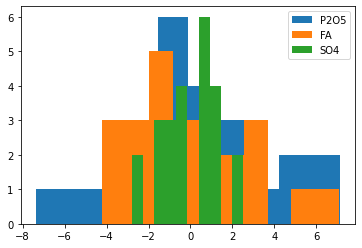

In [107]:
pred=predics5
predics5_y1_vbp=pred[:,0]
error5_y1_vbp=(predics5_y1_vbp-T5[:,0])/T5[:,0]*100
predics5_y2_vbp=pred[:,1]
error5_y2_vbp=(predics5_y2_vbp-T5[:,1])/T5[:,1]*100
predics5_y3_vbp=pred[:,2]
error5_y3_vbp=(predics5_y3_vbp-T5[:,2])/T5[:,2]*100

plt.hist(error5_y3_vbp)
plt.hist(error5_y2_vbp)
plt.hist(error5_y1_vbp)
plt.legend(['P2O5', 'FA', 'SO4'])
plt.show()

In [108]:
fig = make_subplots(rows=1, cols=3, subplot_titles=("SO4", "FA", "P2O5"), column_widths=[0.33, 0.33, 0.33],
                     specs=[[{"secondary_y": True}, {"secondary_y": True}, {"secondary_y": True}]])

fig.add_trace(go.Scatter(x=T5[:,0] , y=predics5_y1_vbp, mode='markers', marker_size=4, text=data5.exp, name='predics SO4', marker_color='black' ), 1, 1)
fig.add_trace(go.Scatter(x=T5[:,1] , y=predics5_y2_vbp, mode='markers', marker_size=4, text=data5.exp, name='predics FA', marker_color='black' ), 1, 2)
fig.add_trace(go.Scatter(x=T5[:,2] , y=predics5_y3_vbp, mode='markers', marker_size=4, text=data5.exp, name='predics P2O5', marker_color='black' ), 1, 3)

fig.add_trace(go.Scatter(x=T5[:,0] , y=error5_y1_vbp, mode='markers', marker_size=4, text=data5.exp, name='error SO4', marker_color='orange' ), 1, 1, secondary_y=True,)
fig.add_trace(go.Scatter(x=T5[:,1] , y=error5_y2_vbp, mode='markers', marker_size=4, text=data5.exp, name='error FA', marker_color='orange' ), 1, 2, secondary_y=True,)
fig.add_trace(go.Scatter(x=T5[:,2] , y=error5_y3_vbp, mode='markers', marker_size=4, text=data5.exp, name='error P2O5', marker_color='orange' ), 1, 3, secondary_y=True,)

fig.update_layout(title='', autosize=True,
                  width=1550, height=400,
                  margin=dict(l=0, r=0, b=0, t=30))

fig.update_xaxes(title_text="", range=[0.5, 2], row=1, col=1)
fig.update_yaxes(title_text="", range=[0.5, 2], row=1, col=1)
fig.update_yaxes(title_text="%error", range=[-10, 10], row=1, col=1, secondary_y=True, showgrid=False, tick0=-10, dtick=2)

fig.update_xaxes(title_text="", range=[0, 30], row=1, col=2)
fig.update_yaxes(title_text="", range=[0, 30], row=1, col=2)
fig.update_yaxes(title_text="%error", range=[-10, 10], row=1, col=2, secondary_y=True, showgrid=False, tickvals=[-10,-5,-1,0,1,5,10])

fig.update_xaxes(title_text="", range=[0.5, 2], row=1, col=3)
fig.update_yaxes(title_text="", range=[0.5, 2], row=1, col=3)
fig.update_yaxes(title_text="%error", range=[-10, 10], row=1, col=3, secondary_y=True, showgrid=False, tick0=-10, dtick=2)

fig.show()